# NB pour tester la génération de processus sto 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from generate_BM import gen_N_fbm, variogram, gen_BM, Ito, euler_maruyama, path_simulation
import yfinance as yf 
import pandas_datareader as pdr

%load_ext autoreload
%autoreload 2

In [ ]:
def f(x):
    return 1

N = 10 ** 3
T = 1000
times = np.linspace(0, T, 1000)

list_integrals = []

for t in times:
    list_integrals.append(Ito())

plt.plot(list_integrals) # bizarre le plot on dirait un BM super serré 

: 

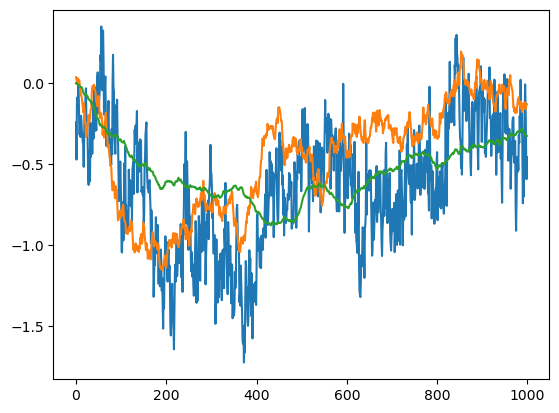

In [ ]:
T = 1000

x_25 = gen_N_fbm(T, 0.25)
x_50 = gen_N_fbm(T, 0.5)
x_75 = gen_N_fbm(T, 0.75)
plt.plot(x_25)
plt.plot(x_50)
plt.plot(x_75)
plt.show()
# note that the curves have been rescaled 

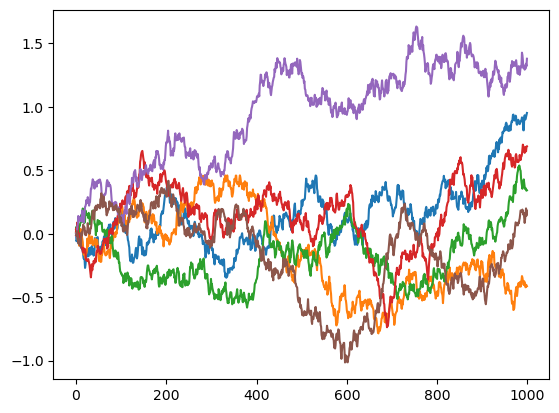

In [5]:
T = 1000
N = 6

x = gen_N_fbm(T, 0.5, N)
for i in range(x.shape[1]):
    plt.plot(x[:,i])

### variogramme de FBM (variogram vs time lag)

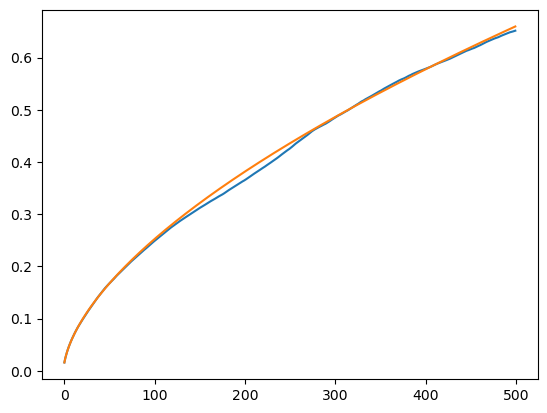

In [87]:
H = 0.3
T = 1000
df = pd.DataFrame(gen_N_fbm(T=T, H=H, N =100))
taus = np.arange(1,501,1)
vario = [variogram(tau=tau, df=df) for tau in taus]
plt.plot(vario)
plt.plot(taus ** (2 * H) / T ** (2*H)) ## valeur th 

### plot de signature 

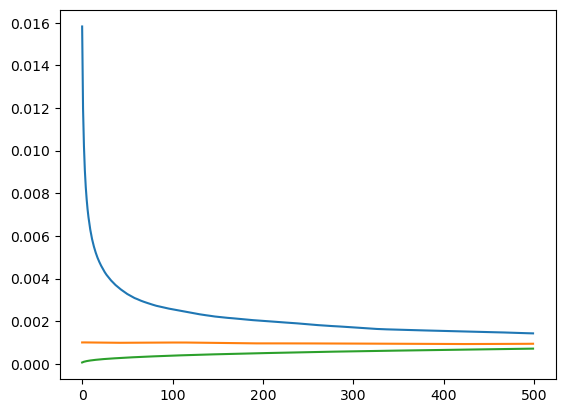

In [88]:
H_30 = 0.3
H_50 = 0.5 
H_70 = 0.7
T = 1000
df_1 = pd.DataFrame(gen_N_fbm(T=T, H=H_30, N =100))
df_2 = pd.DataFrame(gen_N_fbm(T=T, H=H_50, N =100))
df_3 = pd.DataFrame(gen_N_fbm(T=T, H=H_70, N =100))
taus = np.arange(1,501,1)
signature_30 = [variogram(tau=tau, df=df_1) / tau for tau in taus]
signature_50 = [variogram(tau=tau, df=df_2) / tau for tau in taus]
signature_70 = [variogram(tau=tau, df=df_3) / tau for tau in taus]
plt.plot(signature_30)
plt.plot(signature_50)
plt.plot(signature_70)


## On constate que pour H = 0.3 le processus est superdiffusif 


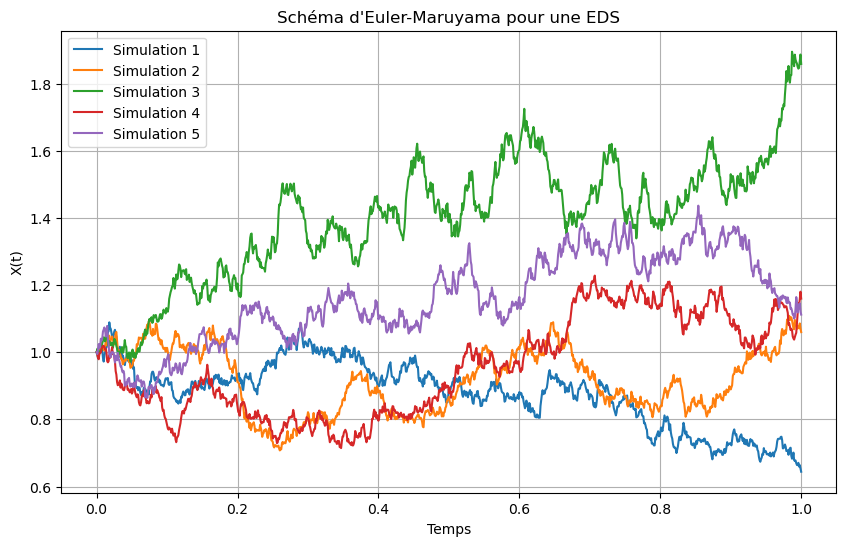

In [ ]:
mu = 0.03           
sigma = 0.4        
x0 = 1           
T = 1.0            
N = 1000           
dt = T / N         
num_simulations = 5 

plt.figure(figsize=(10, 6))
for i in range(num_simulations):
    t, X = euler_maruyama(mu, sigma, x0, T, N)
    plt.plot(t, X, label=f"Simulation {i + 1}")

plt.title("Schéma d'Euler-Maruyama pour une EDS")
plt.xlabel("Temps")
plt.ylabel("X(t)")
plt.legend()
plt.grid()
plt.show()

# Dimension d 

[*********************100%***********************]  3 of 3 completed

Ticker     ^FCHI     ^GSPC     ^IXIC
Ticker                              
^FCHI   0.000157  0.000084  0.000088
^GSPC   0.000084  0.000120  0.000133
^IXIC   0.000088  0.000133  0.000164


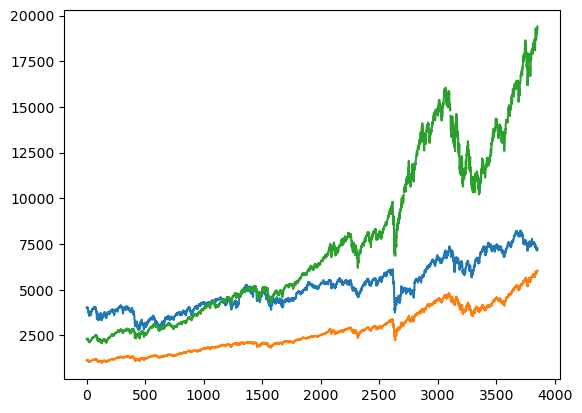

In [18]:
index = ['^GSPC', '^IXIC', '^FCHI'] # S&P 500, NASDAQ CAC ['AAPL', 'XOM']

interval = '1d'

def frequency(interval):
    if interval == '1mo':
        return 12
    if interval == '1y':
        return 1
    if interval == '1d':
        return 252

market_data = yf.download(index, start='2010-01-01', interval=interval).reset_index()
market_data["Date"] = market_data["Date"].dt.strftime('%Y/%m')
market_data = market_data[["Date", "Adj Close"]]

market_returns = np.log(market_data['Adj Close']) - np.log(market_data['Adj Close'].shift(1))
market_returns.dropna(inplace=True)
mean_returns = market_returns.mean().values
cov_market = market_returns.cov() 
print(cov_market)
cov_market.values

plt.plot(market_data['Adj Close'])

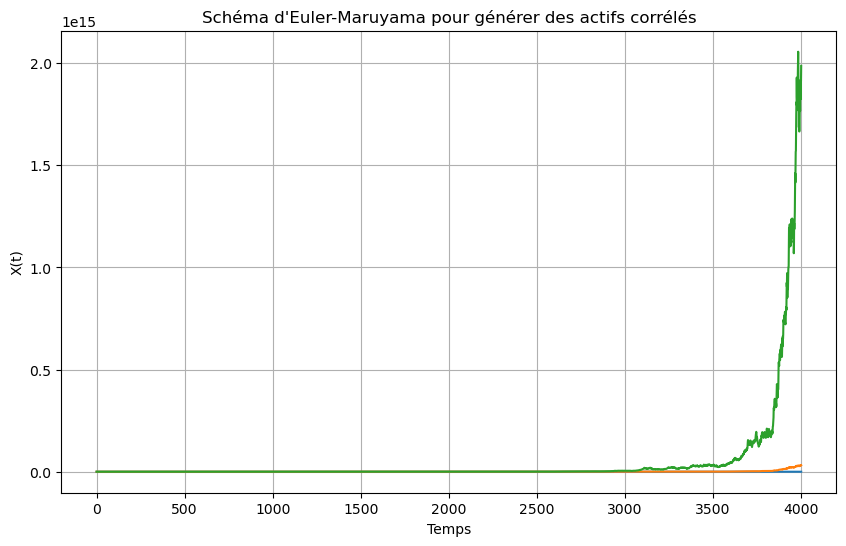

In [19]:
# BOF BOF 

T = 1 # n years           
N = 4000 # datapoints      
dt = T / N # fréquence de la data     
scaling_factor =  frequency(interval) / dt # pour annualiser la matrice de cov puis l'adapter à la fréquence voulue
mu = mean_returns * N * 12 
cov = cov_market * N * 12  #* np.sqrt(scaling_factor)       
X0 = market_data['Adj Close'].iloc[0,:].values 
d = 2     
num_simulations = 1

plt.figure(figsize=(10, 6))
for i in range(num_simulations):
    X = path_simulation(mu, cov, X0, T, N)
    plt.plot(X, label=f"Simulation {i + 1}")

plt.title("Schéma d'Euler-Maruyama pour générer des actifs corrélés")
plt.xlabel("Temps")
plt.ylabel("X(t)")
#plt.legend()
plt.grid()
plt.show()


## Simulation de returns

In [17]:
from simulation import simulate_normal_returns

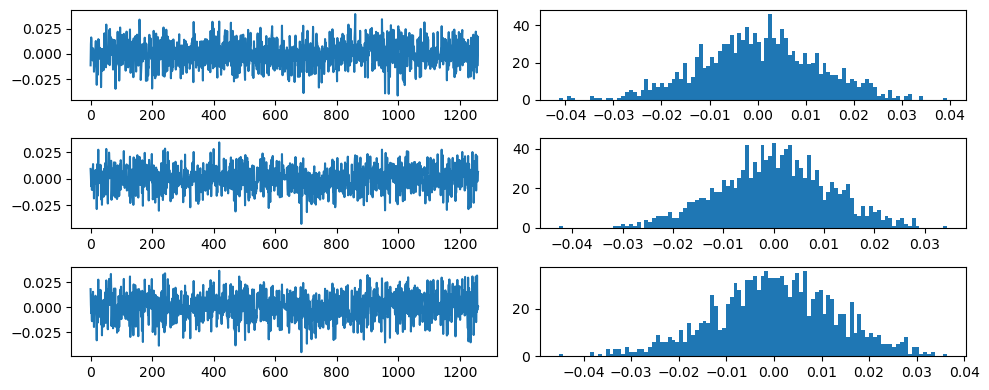

la fréquence des returns est : 1d


In [52]:
simulated_returns = simulate_normal_returns(mu = mean_returns, cov = cov_market, N=252 * 5, n_simul=1)

fig, ax = plt.subplots(len(mean_returns), 2, figsize=(10,4))
for i in range(len(mean_returns)):
    ax[i, 0].plot(simulated_returns[:,i])
    ax[i, 1].hist(simulated_returns[:,i], bins=100)
plt.tight_layout()
plt.show()


print("la fréquence des returns est :",interval)


In [ ]:
# import pystable

# init_fit = {'alpha': 2, 'beta': 0, 'sigma': 1, 'mu': 0,
#             'parameterization': 1}
# dist = pystable.create(init_fit['alpha'], init_fit['beta'],
#                        init_fit['sigma'], init_fit['mu'],
#                        init_fit['parameterization'])

# pystable.fit(dist, market_returns, len(market_returns))
# fit_params = [dist.contents.alpha, dist.contents.beta,
            #   dist.contents.sigma, dist.contents.mu_0, dist.contents.mu_1]

OSError: dlopen(/opt/anaconda3/lib/python3.12/site-packages/pystable/_extensions/macOS/arm/libstable.so, 0x0006): Library not loaded: /opt/homebrew/opt/gsl/lib/libgsl.25.dylib
  Referenced from: <982B597B-B8C1-3A35-891A-EE6ED8EE6C59> /opt/anaconda3/lib/python3.12/site-packages/pystable/_extensions/macOS/arm/libstable.so
  Reason: tried: '/opt/homebrew/opt/gsl/lib/libgsl.25.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/gsl/lib/libgsl.25.dylib' (no such file), '/opt/homebrew/opt/gsl/lib/libgsl.25.dylib' (no such file), '/usr/local/lib/libgsl.25.dylib' (no such file), '/usr/lib/libgsl.25.dylib' (no such file, not in dyld cache), '/opt/homebrew/Cellar/gsl/2.8/lib/libgsl.25.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/Cellar/gsl/2.8/lib/libgsl.25.dylib' (no such file), '/opt/homebrew/Cellar/gsl/2.8/lib/libgsl.25.dylib' (no such file), '/usr/local/lib/libgsl.25.dylib' (no such file), '/usr/lib/libgsl.25.dylib' (no such file, not in dyld cache)

### Quelques "faits stylisés"

In [ ]:
index = ['^GSPC'] # S&P 500

market_data = yf.download(index, interval='1d').reset_index()
market_data["Date"] = market_data["Date"].dt.strftime('%Y/%m')
market_data = market_data[["Date", "Adj Close"]] 

[*********************100%***********************]  1 of 1 completed


In [57]:
#market_data = pd.read_csv('1_min_SPY_2008-2021.csv', index_col=0)
#close = market_data['close']

In [85]:
market_data
close = market_data["Adj Close"]['^GSPC']

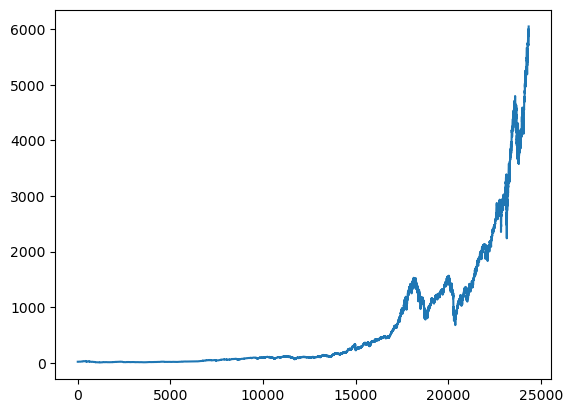

In [70]:
plt.plot(close)

In [71]:
market_data['a_returns'] = close - close.shift(1)
market_data['l_returns'] = np.log(close / close.shift(1))

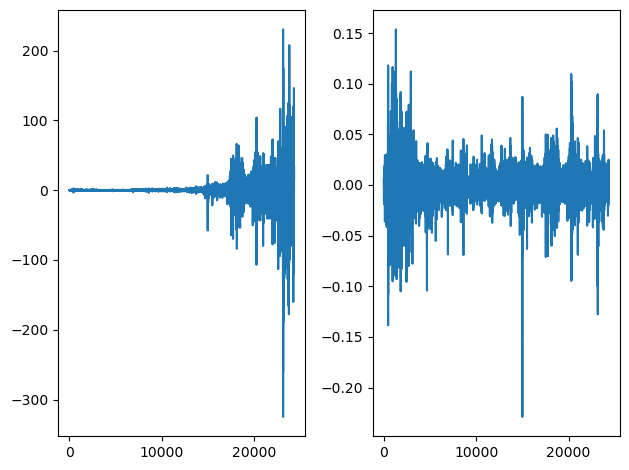

In [72]:
plt.subplot(121)
plt.plot(market_data['a_returns'])
plt.subplot(122)
plt.plot(market_data['l_returns'])
plt.tight_layout()

In [ ]:
def variogram_log_p(tau, series):
    log_ret_delta = np.log(series) - np.log(series).shift(tau)
    log_ret_delta_squared = log_ret_delta ** 2 
    return log_ret_delta_squared.mean()

### Faudra changer la fonction qu'on importe...

taus = np.arange(0, 500)

vario = []
for tau in taus:
    vario.append(variogram_log_p(tau=tau, series=close))

[]

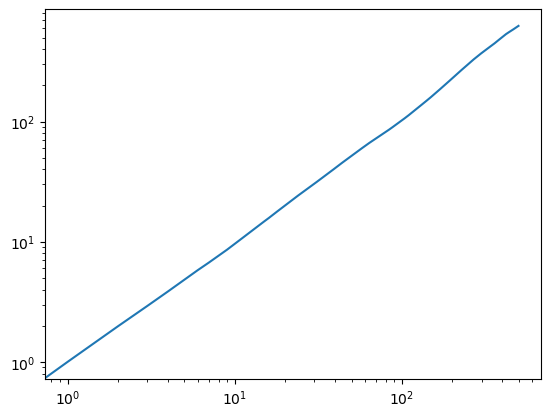

In [89]:
plt.plot(vario / vario[1])
plt.loglog()

daily scale
0.00023971248512978264
0.011955260696328813
annual scale
0.05801147820416171
0.19929715588703278


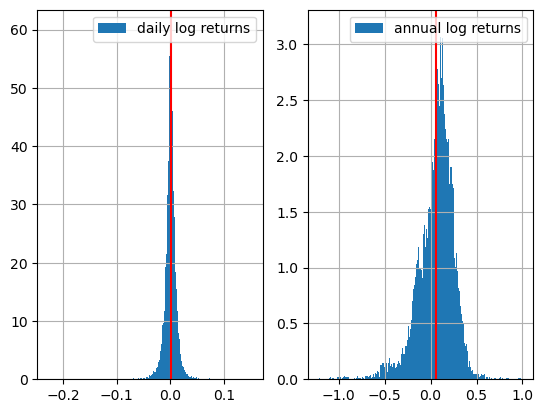

In [105]:
def compute_returns_scale(series, delta=1):
    log_ret_delta = np.log(series) - np.log(series).shift(delta)
    return log_ret_delta

r_1 = compute_returns_scale(close, 1)
r_250 = compute_returns_scale(close, 250)

print("daily scale")
print(r_1.mean())
print(r_1.std())

print("annual scale")
print(r_250.mean())
print(r_250.std())
    
    
plt.subplot(121)
plt.hist(r_1, bins=300, label='daily log returns', density=True)
plt.legend()
plt.grid()
plt.axvline(r_1.mean(), color='red')
plt.subplot(122)
plt.hist(r_250, bins=300, label='annual log returns', density=True)
plt.legend()
plt.grid()
plt.axvline(r_250.mean(), color='red')
plt.show()